In [1]:
import pylab as pl
from scipy.optimize import minimize

from utils import *
from grm_utils import *

In [2]:
# step 1: read catalogues
xmm12_file = '/Users/ascaife/DATA/MIGHTEE/catalog/XMMLSS/XMMLSS_12/XMMLSS_12_1538856059_1539286252_pol_detections.fits'
xmm12 = read_catalogue(xmm12_file)
xmm13_file = '/Users/ascaife/DATA/MIGHTEE/catalog/XMMLSS/XMMLSS_13/XMMLSS_13_1538942495_1539372679_pol_detections.fits'
xmm13 = read_catalogue(xmm13_file)
xmm14_file = '/Users/ascaife/DATA/MIGHTEE/catalog/XMMLSS/XMMLSS_14/XMMLSS_14_1539028868_1539460932_pol_detections.fits'
xmm14 = read_catalogue(xmm14_file)
cosmos_file = '/Users/ascaife/DATA/MIGHTEE/catalog/COSMOS/COSMOS_1587911796_1524147354_1525613583_pol_detections.fits'
cosmos = read_catalogue(cosmos_file)

In [3]:
# step 2: merge catalogues
mightee = merge_cats([xmm12, xmm13, xmm14, cosmos])
print('# of sources: {}'.format(mightee.shape[0]))

# of sources: 442


In [4]:
# step 3: redshift and galactic latitude filtering
mightee = filter_z(mightee, has_z=True, spec_z=False)
print('# of sources (after z filter): {}'.format(mightee.shape[0]))

# add columns for (l,b)
mightee['l'], mightee['b'] = j2000_to_gal(mightee['ra'].values, mightee['dec'].values)

# filter b<25:
mightee = filter_glat(mightee, bmin=25.)
print('# of sources (after b filter): {}'.format(mightee.shape[0]))

# step 4: get GRMs
ra = np.array(mightee['ra'].values)
dec= np.array(mightee['dec'].values)

fitsfile = './faradaysky/faraday2020v2.fits'
grmdata, grmhp = get_grm_data(fitsfile) # from grm_utils.py

# nearest pixel values:
grm_fs, grm_fs_std = get_grm(ra, dec, grmdata, grmhp) # from grm_utils.py
mightee['GRM_FS'] = grm_fs
mightee['GRM_FSerr'] = grm_fs_std

# 1 degree median values:
grm1_med, grm1_mad, grm1_std = get_grm1(ra, dec, grmdata, grmhp, r=0.5) # 1 degree median values (grm_utils)
mightee['GRM1'] = grm1_med
mightee['GRM1err'] = grm1_mad

# of sources (after z filter): 313
# of sources (after b filter): 313


In [5]:
def bin_rrm(rrm, bins, idx_bin, n_bin):
    
    sig_rrm= [np.std(rrm[idx_bin == j]) for j in range(1, len(bins))]
    ste_sig = standard_error_on_stdev(sig_rrm, n_bin)

    return sig_rrm, ste_sig

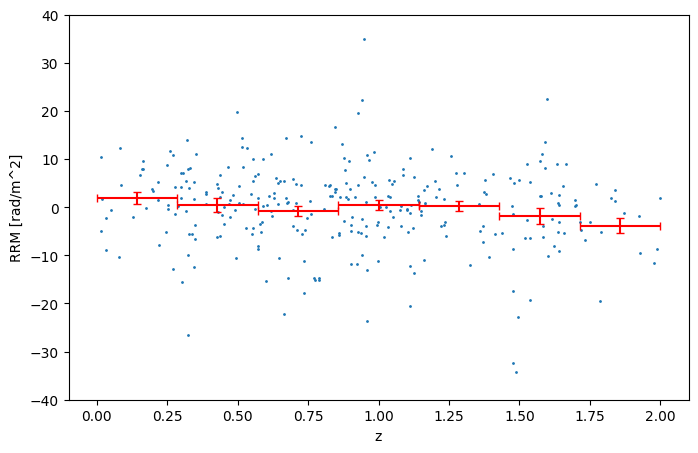

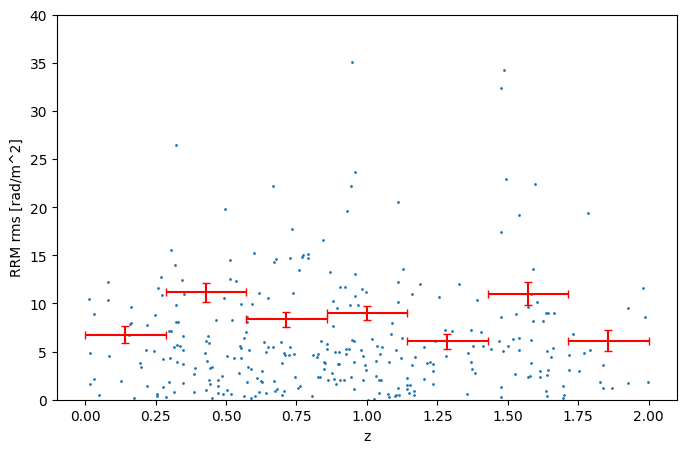

In [6]:
# step 7: redshift binning
rm      = mightee['RM'].values
rm_err  = mightee['RM_err'].values
grm     = mightee['GRM_FS'].values      # use 1 deg median
grm_err = mightee['GRM_FSerr'].values   # use 1 deg median
grm1    = mightee['GRM1'].values        # use 1 deg median
z       = mightee['best_z'].values

rrm = rm - grm1

std = np.std(rrm)
z = z[np.where(np.abs(rrm)<=2*std)]
rrm = rrm[np.where(np.abs(rrm)<=2*std)]

bins, idx_bin, n_bin = bin_z(z, nbins=7)
mu_bin = 0.5*np.diff(bins)+bins[:-1]

mu_rrm = [np.average(rrm[idx_bin == j]) for j in range(1, len(bins))]
sig_rrm= [np.std(rrm[idx_bin == j]) for j in range(1, len(bins))]
ste_rrm= sig_rrm/np.sqrt(n_bin)
ste_sig = standard_error_on_stdev(sig_rrm, n_bin)

pl.rcParams["figure.figsize"] = (8,5)
pl.scatter(z, rrm, s=1)
pl.errorbar(mu_bin, mu_rrm, yerr=ste_rrm, xerr=0.5*np.diff(bins), c='red', ls='', capsize=3.)
pl.xlabel('z')
pl.ylabel('RRM [rad/m^2]')
pl.ylim(-40,40)
pl.savefig('./plots/mightee_rrm_z.png')
pl.show()

pl.scatter(z, np.abs(rrm), s=1)
pl.errorbar(mu_bin, sig_rrm, yerr=ste_sig, xerr=0.5*np.diff(bins), c='red', ls='', capsize=3.)
pl.xlabel('z')
pl.ylabel('RRM rms [rad/m^2]')
pl.ylim(0,40)
pl.savefig('./plots/mightee_rrmrms_z.png')
pl.show()

In [15]:
print(np.array(mu_rrm)/np.array(ste_rrm))

[ 1.51081463  0.32523075 -0.75250019  0.48150287  0.27040499 -1.08058184
 -2.49807099]


In [7]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([0., 10., 1.]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(mu_bin, sig_rrm, ste_sig))
m_ml, b_ml, log_f_ml = soln.x
ih = soln.hess_inv

print("Maximum likelihood estimates:")
print("m = {:.3f}+/-{:.3f}".format(m_ml, np.sqrt(ih[0,0])))
print("b = {:.3f}+/-{:.3f}".format(b_ml, np.sqrt(ih[1,1])))
print("f = {:.3f}+/-{:.3f}".format(np.exp(log_f_ml), np.sqrt(ih[2,2])))

Maximum likelihood estimates:
m = -0.555+/-1.372
b = 8.831+/-1.575
f = 0.200+/-0.385


In [8]:
def zdep(rrm, z, model='C1'):
    
    if model=='C1':
        rrm0 = rrm*(1+z)**2
    elif model=='C2':
        rrm0 = rrm*((1+z)**3-1)
        rrm0/= 3*z
    elif model=='C3':
        rrm0 = rrm*(1+z)
    
    return rrm0

In [9]:
df = pd.DataFrame(mu_bin, columns=["z"])
df["n_src"] = n_bin
df["RRM mean"] = mu_rrm
df["RRM ste"] = ste_rrm
df["RRM rms"] = sig_rrm
df["RRM sig"] = ste_sig

rrm0 = zdep(rrm, z, model='C1')
df["C1 rms"], df["C1 sig"] = bin_rrm(rrm0, bins, idx_bin, n_bin)

rrm0 = zdep(rrm, z, model='C2')
df["C2 rms"], df["C2 sig"] = bin_rrm(rrm0, bins, idx_bin, n_bin)

rrm0 = zdep(rrm, z, model='C3')
df["C3 rms"], df["C3 sig"] = bin_rrm(rrm0, bins, idx_bin, n_bin)

In [10]:
df.head(10)

,z,n_src,RRM mean,RRM ste,RRM rms,RRM sig,C1 rms,C1 sig,C2 rms,C2 sig,C3 rms,C3 sig
0,0.142857,29,1.890195,1.251110,6.737432,0.884668,9.320529,1.223845,7.960575,1.045275,7.874128,1.033924
1,0.428571,61,0.464858,1.429319,11.163335,1.010681,25.065747,2.269346,17.605693,1.593945,16.656499,1.508009
2,0.714286,59,-0.818451,1.087643,8.354344,0.769080,24.693099,2.273184,15.785311,1.453156,14.335013,1.319645
3,1.000000,71,0.514255,1.068021,8.999302,0.755205,35.248289,2.957971,20.670095,1.734596,17.785634,1.492537
4,1.285714,31,0.294118,1.087694,6.056025,0.769116,31.660193,4.020849,17.176062,2.181362,13.828360,1.756203
5,1.571429,43,-1.815708,1.680306,11.018502,1.188156,70.447208,7.596518,36.433709,3.928748,27.847070,3.002827
6,1.857143,16,-3.839809,1.537110,6.148439,1.086901,49.939813,8.828195,24.522130,4.334941,17.501092,3.093785


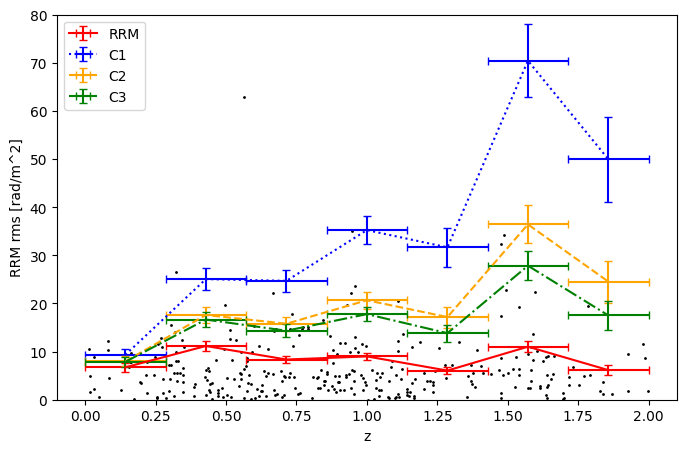

In [11]:
pl.scatter(z, np.abs(rrm), c='black', s=1)
pl.errorbar(mu_bin, sig_rrm, yerr=ste_sig, xerr=0.5*np.diff(bins), c='red', ls='-', capsize=3., label='RRM')
pl.errorbar(mu_bin, df["C1 rms"].values, yerr=df["C1 sig"].values, xerr=0.5*np.diff(bins), c='blue', ls='dotted', capsize=3., label='C1')
pl.errorbar(mu_bin, df["C2 rms"].values, yerr=df["C2 sig"].values, xerr=0.5*np.diff(bins), c='orange', ls='dashed', capsize=3., label='C2')
pl.errorbar(mu_bin, df["C3 rms"].values, yerr=df["C3 sig"].values, xerr=0.5*np.diff(bins), c='green', ls='dashdot', capsize=3., label='C3')
pl.xlabel('z')
pl.ylabel('RRM rms [rad/m^2]')
pl.ylim(0,80)
pl.legend()
pl.savefig('./plots/mightee_cmods.png')
pl.show()

In [17]:
# C1 evolution fit:
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([0., 10., 1.]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(mu_bin, df["C1 rms"].values, df["C1 sig"].values))
m_ml, b_ml, log_f_ml = soln.x
ih = soln.hess_inv

print("Maximum likelihood estimates:")
print("m = {:.3f}+/-{:.3f}".format(m_ml, np.sqrt(ih[0,0])))
print("b = {:.3f}+/-{:.3f}".format(b_ml, np.sqrt(ih[1,1])))
print("f = {:.3f}+/-{:.3f}".format(np.exp(log_f_ml), np.sqrt(ih[2,2])))

Maximum likelihood estimates:
m = 28.976+/-4.798
b = 6.238+/-2.706
f = 0.185+/-0.389


In [18]:
# C2 evolution fit:
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([0., 10., 1.]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(mu_bin, df["C2 rms"].values, df["C2 sig"].values))
m_ml, b_ml, log_f_ml = soln.x
ih = soln.hess_inv

print("Maximum likelihood estimates:")
print("m = {:.3f}+/-{:.3f}".format(m_ml, np.sqrt(ih[0,0])))
print("b = {:.3f}+/-{:.3f}".format(b_ml, np.sqrt(ih[1,1])))
print("f = {:.3f}+/-{:.3f}".format(np.exp(log_f_ml), np.sqrt(ih[2,2])))

Maximum likelihood estimates:
m = 12.178+/-3.072
b = 7.802+/-2.311
f = 0.193+/-0.385


In [19]:
# C3 evolution fit:
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([0., 10., 1.]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(mu_bin, df["C3 rms"].values, df["C3 sig"].values))
m_ml, b_ml, log_f_ml = soln.x
ih = soln.hess_inv

print("Maximum likelihood estimates:")
print("m = {:.3f}+/-{:.3f}".format(m_ml, np.sqrt(ih[0,0])))
print("b = {:.3f}+/-{:.3f}".format(b_ml, np.sqrt(ih[1,1])))
print("f = {:.3f}+/-{:.3f}".format(np.exp(log_f_ml), np.sqrt(ih[2,2])))

Maximum likelihood estimates:
m = 7.358+/-2.950
b = 9.133+/-2.638
f = 0.207+/-0.366


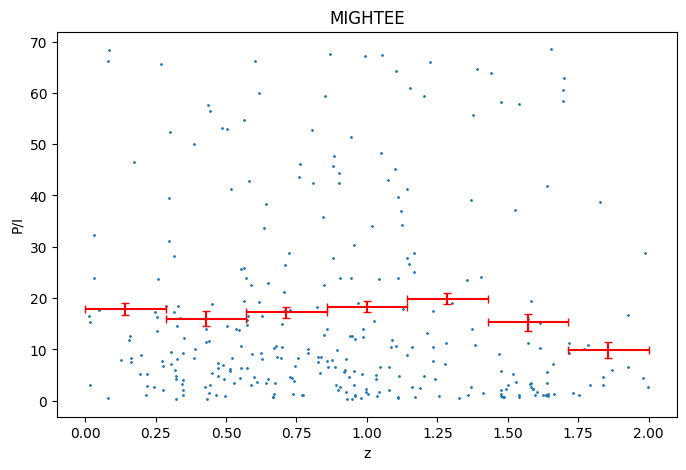

In [12]:
# step 7: redshift binning
rm      = mightee['RM'].values
rm_err  = mightee['RM_err'].values
grm1    = mightee['GRM1'].values        # use 1 deg median
z       = mightee['best_z'].values
pfrac   = mightee['P/I'].values

rrm = rm - grm1

std = np.std(rrm)
z = z[np.where(np.abs(rrm)<=2*std)]
pfrac = pfrac[np.where(np.abs(rrm)<=2*std)]

bins, idx_bin, n_bin = bin_z(z, nbins=7)
mu_bin = 0.5*np.diff(bins)+bins[:-1]

mu_pf = [np.average(pfrac[idx_bin == j]) for j in range(1, len(bins))]
sig_pf= [np.std(pfrac[idx_bin == j]) for j in range(1, len(bins))]
ste_pf= sig_rrm/np.sqrt(n_bin)
ste_sig = standard_error_on_stdev(sig_rrm, n_bin)

pl.rcParams["figure.figsize"] = (8,5)
pl.scatter(z, pfrac, s=1)
pl.errorbar(mu_bin, mu_pf, yerr=ste_pf, xerr=0.5*np.diff(bins), c='red', ls='', capsize=3.)
pl.xlabel('z')
pl.ylabel('P/I')
pl.title('MIGHTEE')
pl.savefig('./plots/mightee_pfracz.png')
pl.show()